# Design Space Exploration with Kriging

This notebook is an exploration of using kriging models to approximate complex response surfaces. The kriging model is a flexible metamodel that can reproduce complex response surfaces given a limited number of observations. The kriging model is a statistics-based model that can include both a traditional response surface and a kernel-based, spatial correlation model.

The desire is to use the prediction capability of the model to drive the exploration of the design space. The methodology controls an adapative design of experiments and also an assessment of the quality of the model based upon the observations used to create the model.

For this example, the Osio and Amon function is used as defined below. This is a two-dimensional function defined over the unit square $[0,1]^2$. This function is highly nonlinear in the first dimension and linear in the second dimension. There is no interaction between the dimensions other than a linear combination of factors.

In [1]:
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def OandA(x0, x1):
    y = np.cos(6*(x0 - 0.5))+3.1*(abs(x0-0.7))+2.0*(x0-0.5)+np.sin(1.0/(abs(x0-0.5)+0.31))+0.5*x1
    return y

The function can be evaluated as shown next.

In [3]:
OandA(0.0, 0.5)

1.3740132321106997

The first step in this process is to provide a visualization of the original response surface. This is completed by evaluating the model over a grid of $100x100$ observations. It is then plotted below. 

In [4]:
dx = np.linspace(0, 1, 100)
dy = np.linspace(0, 1, 100)
X, Y = np.meshgrid(dx, dy)
Z = OandA(X, Y)

C:\Users\jdm111\.conda\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


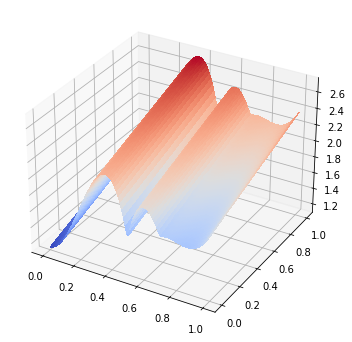

In [5]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,  cmap=plt.cm.coolwarm,linewidth=0, antialiased=False)
fig.show()


## Fixed Design of Experiments

Here are 21 locations within the model's domain selected using a Latin Hypercube Sampling (LHS) Design of Experiments (DoE)

(0.0, 1.0)

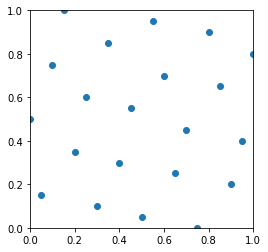

In [6]:
data=np.array([[0.0, 0.5],
      [0.05, 0.15],
      [0.1, 0.75],
      [0.15, 1.0],
      [0.2, 0.35],
      [0.25, 0.6],
      [0.3, 0.1],
      [0.35, 0.85],
      [0.4, 0.3],
      [0.45, 0.55],
      [0.5, 0.05],
      [0.55, 0.95],
      [0.6, 0.7],
      [0.65, 0.25],
      [0.7, 0.45],
      [0.75, 0.0],
      [0.8, 0.9],
      [0.85, 0.65],
      [0.9, 0.2],
      [0.95, 0.4],
      [1.0, 0.8]])

X0=data[:,0]
X1=data[:,1] 

fig, ax = subplots(1,1,figsize=(4,4))
ax.scatter(X0,X1)
ax.set_ylim([0,1])
ax.set_xlim([0,1])

The original model is evaluated at the 21 locations and the two X vectors are assembled into a single matrix. This matrix and the vector of observations, Y, are passed to the Kriging Model creation code.

In [7]:
Y = OandA(X0,X1)
X=np.array([X0, X1]).T

In [8]:
from kriging.kriging import KrigingModel

ModuleNotFoundError: No module named 'utility'

In [9]:
k=KrigingModel(X,Y)

The following information is generated as a result of creating the kriging model. They include a representation of what terms are used in the trend model (selected automatically), and trend model coefficients, correlation model range parameters, the corrected AIC, and the overall process variance.

In [10]:
print k.trendModel
print 'beta:',k.beta
print 'corr range:', k.d
print 'corrrected AIC:', k.getAICc()
print 'process variance:', k.processVariance

[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
beta: [ 1.71240643  0.53632377]
corr range: [ 0.1157375   2.72582116]
corrrected AIC: -7.21854178949
process variance: 0.0869960551963


The model can then be evaluated at a location within its domain ($[0,1]^2$).

In [11]:
k.estimate([0.1,0.1])

1.3685844698708096

This can be compared to the original model.

In [12]:
OandA(0.1, 0.1)

1.3594571519619068

The standard deviation of the model's estimate can be quantified. This metric does not include the uncertainty that exists in predicting the model parameters.

In [13]:
k.stdev([0.1,0.1])

0.05848426699546762

Since the uncertainty that exists in estimating the model parameters is nto included, it is expected that the standard deviation estimate may be an underestimate of the actual standard deviation in the estimates. This can be analyzed by evaluating the kriging model and the actual model at a number of random locations within its domain. The difference between the estimate and the actual value can be normalized by the expected standard deviation at the location and then plotted as a histogram. Additionally, the mean, variance, skewness, and kurtosis can be calculated from the observed normalized errors. The expected mean should be zero, variance should be one, skewness zero, and kurtosis should be three, ie. it should result in a standard normal distribution.

<Container object of 20 artists>

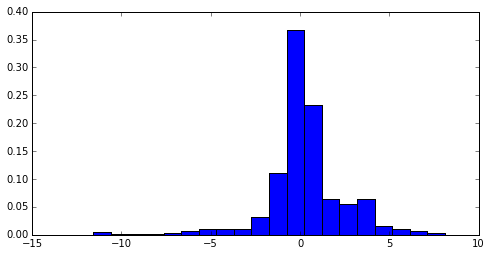

In [14]:
from random import random
num_points = 1000
obs = np.zeros((num_points))
for i in range(num_points):
    x0=random()
    x1=random()
    delta = OandA(x0,x1)-k.estimate([x0,x1])
    obs[i] = delta/k.stdev([x0,x1])
hist, bins = np.histogram(obs, bins=20, density=True) 
widths = np.diff(bins)

fig, ax = subplots(1,1,figsize=(8,4))
ax.bar(bins[:-1], hist, widths)

In [15]:
from scipy import stats
n, min_max, mean, var, skew, kurt = stats.describe(obs)
print 'mean:',mean
print 'var :', var
print 'skew:', skew
print 'kurt:', kurt

mean: 0.310262801552
var : 4.93191289772
skew: -0.885826234516
kurt: 5.68504978483


As the reader can see from both the visual inspection of the resulting histogram of the standardized errors of the observation predictions and the description statistics, the standardized errors are not well described with a normal distribution. The mean is good, but the variance is large and is driven by the outliers. These outliers also drive the kurtosis (a measurement of the thickness of the tails) to be much more than the expected value of 3.

Previous research by the author has shown that, by including all of the uncertainty in the model parameters, the resulting distribution is well approximated by the student-t distribution (has thicker tails) and can have a significantly higher variance than that given only by the model variance. In the study of this specific model, it was found that the model parameters only tended to increase the uncertainty by about 20%, which is less than that being observed here.

The following two plots provide a comparison of the response surfaces from the original function and the surrogate model created from 21 observations of the original model.

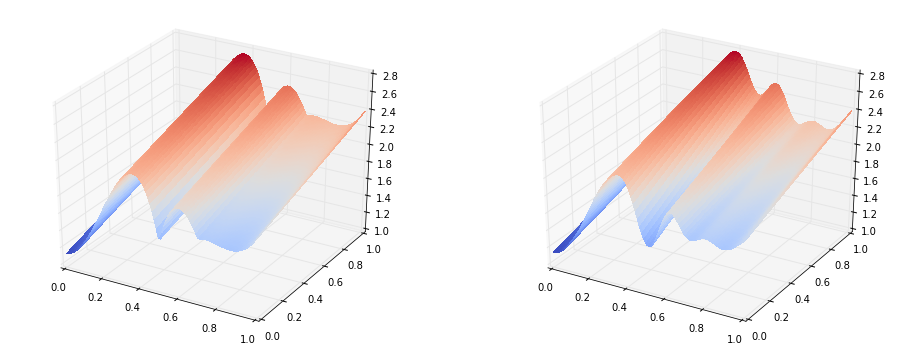

In [16]:
dx = linspace(0, 1, 100)
dy = linspace(0, 1, 100)
X, Y = meshgrid(dx, dy)
Z_est = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        Z_est[i,j]=k.estimate([X[i,j],Y[i,j]])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z, rstride = 1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z_est, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)


It is difficult to see much of a difference in these plots. It is easier to see the differences in the following plot. The points included in the plot are the observations points. It is expected that the model would interpolate these points. The surface shown does not appear to do so. This is a result of the plotting software 'rounding' of some of the extremely sharp features. The plot below provides the reader with a more qualitative perspective of the error. A more quantative measurement is the root mean square error. The amount of variability in the actual model that is captured by the kriging model can also be quantified.

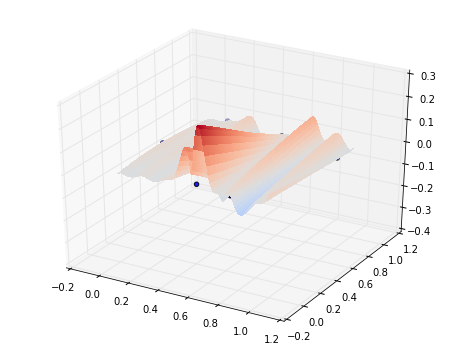

In [17]:
Z_err = np.array(Z-Z_est)
Z_zero = np.zeros((21))-0.0
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_surface(X, Y, Z_err, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X0, X1, Z_zero)

In [18]:
print 'RMSE: ', sqrt(np.sum(np.multiply(Z_err, Z_err))/(100*100))
print 'R^2 : ', 1.0-((np.sum(np.multiply(Z_err, Z_err))/(100*100))/np.var(Z))


RMSE:  0.0517660002044
R^2 :  0.97357151932


The kriging model is capable of reproducing very complex response surfaces, much more so than polynomial regression models, as can be seen in the example above. The basis of the kriging model is that it is a Gaussian spatial process model, i.e. it assumes that the observations come from a Gaussian spatial process. The form of the kriging model allows one to estimate not only the expected value of the response process represented by the observations of it, but also the standard deviation of those estimates. The following figure plots plus and minus one standard deviation as a wireframe with the actual errors. It can be seen that there is only one region where the model does not appear to do a very good job of predicting the actual surface.

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


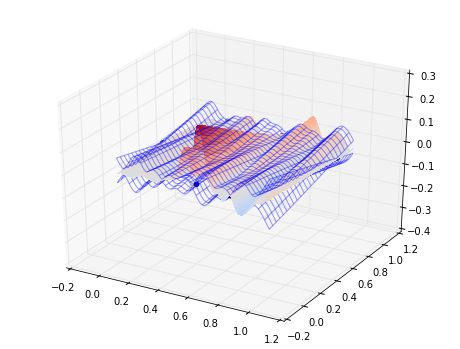

In [19]:
Z_std = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        Z_std[i,j]=k.stdev([X[i,j],Y[i,j]])

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_wireframe(X, Y, Z_std, rstride=4, cstride=4, alpha=0.4)
ax.plot_wireframe(X, Y, -1*Z_std, rstride=4, cstride=4, alpha=0.4)
ax.plot_surface(X,Y,Z_err, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X0, X1, Z_zero)


## Adaptive Design of Experiments

It is remarkable the amount of detail that can be reproduced given only 21 observations selected before anything is known about response surface to be reproduced. The use of kriging models was initially considered for use a metamodel not so much for its powerful ability to reproduce response surfaces, but rather for its ability to be an adaptive design of experiment tool - after an initial screening, the locations of maximum standard deviation (or variance or mean square error) is selected to update the kriging model and thus optimally reduce the uncertainty in the response surface.

The 'seed' design in this case will be observations that still come from an LHS type of design. For a two-dimensional function like this, a minimum of 6 observations is needed (1 for trend function, 2 for correlation parameters, 1 for the process variance, and 2 additional degrees of freedom)

In [20]:
X6=np.array([[0.0, 1.0],
    [0.2, 0.2],
    [0.4, 0.6],
    [0.6, 0.0],
    [0.8, 0.8],
    [1.0, 0.4]])
X6_0=X6[:,0]
X6_1=X6[:,1] 
Y6 = OandA(X6_0,X6_1)

In [21]:
Y6

array([ 1.62401323,  1.82044942,  2.50151549,  1.98151549,  2.08044942,
        2.08401323])

In [22]:
k6=KrigingModel(X6,Y6)
print k6.trendModel
print 'beta:',k6.beta
print 'corr range:', k6.d
print 'corrrected AIC:', k6.getAICc()
print 'process variance:', k6.processVariance

[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
beta: [ 1.97858752]
corr range: [ 10.           0.28323599]
corrrected AIC: 47.9251948027
process variance: 0.0957270709744


The original function on the left can be compared to that on the right. It is obvious that the kriging surrogate model 'just doesn't get it yet.'

error estimate:  0.99208887871
error actual  :  -0.614397564464
cv error      :  0.84685206692
variance      :  0.318425992511


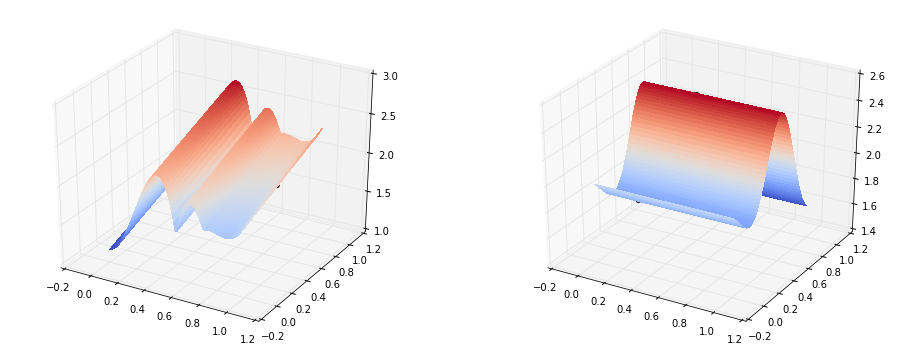

In [23]:
Z6_est = np.zeros((100,100))
z6_std = np.zeros((100,100))
Z6_zero = np.zeros((6))
iea = [0.0]
iee = [0.0]
for i in range(100):
    for j in range(100):
        Z6_est[i,j]=k6.estimate([X[i,j],Y[i,j]])
        z6_std[i,j]=k6.stdev([X[i,j],Y[i,j]])
        iee[0]+=z6_std[i,j]*z6_std[i,j]
        iea[0]+=(Z[i,j]-Z6_est[i,j])*(Z[i,j]-Z6_est[i,j])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z, rstride = 1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X6_0, X6_1, Y6)
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z6_est, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X6_0, X6_1, Y6)
iee[0]=sqrt(iee[0]/(100*100))
iea[0]=sqrt(iea[0]/(100*100))
ecv = [sqrt(k6.cvMSE)]
stdZ = sqrt(np.var(Z))
print "error estimate: ", 1-pow((iee[0]/stdZ),2)
print "error actual  : ", 1-pow((iea[0]/stdZ),2)
print "cv error      : ", 1-pow((ecv[0]/stdZ),2)
print "variance      : ", stdZ


In this adaptive scheme, the next observation to add is the one where the most uncertainty exists. A plot of this uncertainty is shown below. One characteristic of the kriging model is its larger uncertainty on the edges - in regions where it must extrapolate slightly rather than interpolate. The computational effort needed to determine the exact maximum uncertainty thoughout the domain is large and is difficult. It can be seen that the range is multimodal. It is also computationally expensive to calculate the gradient and Hessian of the surface at any location within the domain. 

It is not critical that the absolute maximum be chosen - anything close should be sufficient. As a result, there two approaches that can be taken. The first is to select completely random locations within the domain and select the one that has the largest uncertainty measurement. This has the advantage of taking a fixed amount of time - the number of random locations that are tested. The second approach is to apply a grid search to the problem and take the largest uncertainty within this grid. This approach is taken for this problem since a grid has already been used to plots used to visualize the problem.

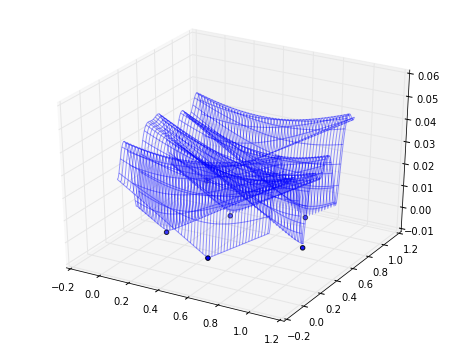

In [24]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_wireframe(X, Y, z6_std, rstride=2, cstride=2, alpha=0.4)
ax.scatter(X6_0, X6_1, Z6_zero)

In [25]:
best_x0 = 0
best_x1 = 0
best_val = z6_std[best_x0,best_x1]
print best_val
for i in range(100):
    for j in range(100):
        if z6_std[i,j]>best_val:
            best_x0 = i
            best_x1 = j
            best_val = z6_std[i,j]
new_point7 = [X[best_x0,best_x1], Y[best_x0, best_x1]]
print best_val, new_point7


0.0261252723704
0.0478879653699 [1.0, 0.10101010101010102]


The largest uncertainty occurs at the x1 edge of the domain. This location is is evaluated in the original model and added to the list of observations. 

In [26]:
y7 = OandA(new_point7[0],new_point7[1])
print y7
Y7 = np.append(Y6, y7)
X7 = np.append(X6,[new_point7], axis=0)

1.93451828262


In [27]:
print Y7, X7

[ 1.62401323  1.82044942  2.50151549  1.98151549  2.08044942  2.08401323
  1.93451828] [[ 0.         1.       ]
 [ 0.2        0.2      ]
 [ 0.4        0.6      ]
 [ 0.6        0.       ]
 [ 0.8        0.8      ]
 [ 1.         0.4      ]
 [ 1.         0.1010101]]


In [28]:
k7 = KrigingModel(X7,Y7)
print k7.trendModel
print 'beta:',k7.beta
print 'corr range:', k7.d
print 'corrrected AIC:', k7.getAICc()
print 'process variance:', k7.processVariance

[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
beta: [ 1.95442445]
corr range: [ 10.           0.27997702]
corrrected AIC: 24.6160703758
process variance: 0.0928183082954


error estimate:  0.0226183711281
error actual  :  0.320737719373
cv error      :  0.102739697664


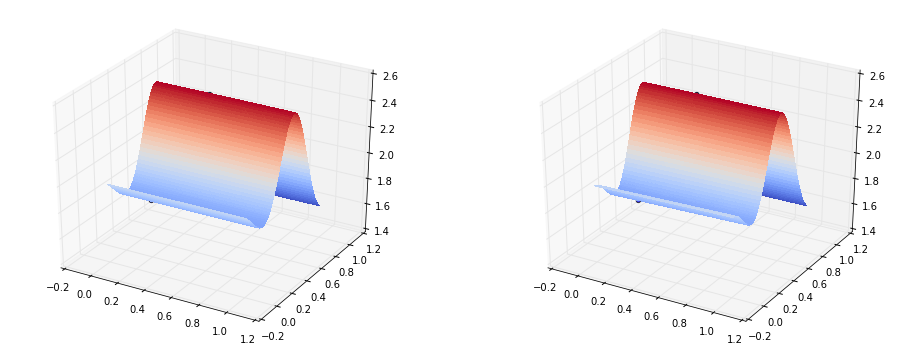

In [29]:
Z7_est = np.zeros((100,100))
z7_std = np.zeros((100,100))
Z7_zero = np.zeros((7))
X7_0 = np.append(X6_0, new_point7[0])
X7_1 = np.append(X6_1, new_point7[1])
iea = np.append(iee,[0.0])
iee = np.append(iea,[0.0])
for i in range(100):
    for j in range(100):
        Z7_est[i,j]=k7.estimate([X[i,j],Y[i,j]])
        z7_std[i,j]=k7.stdev([X[i,j],Y[i,j]])
        iee[1]+=z7_std[i,j]
        iea[1]+=abs(Z[i,j]-Z7_est[i,j])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z6_est, rstride = 1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X6_0, X6_1, Y6)
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z7_est, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X7_0, X7_1, Y7)
iee[1]=iee[1]/(100*100)
iea[1]=iea[1]/(100*100)
ecv = np.append(ecv,[sqrt(k7.cvMSE)])
print "error estimate: ", iee[1]
print "error actual  : ", iea[1]
print "cv error      : ", ecv[1]


As can be seen in the figures above, the resulting response surface with 6 observations (left side) is nearly the same as the response with 7 (right side). A plot of the resulting uncertainty is shown below. The new observation was added in the front corner of the plot.

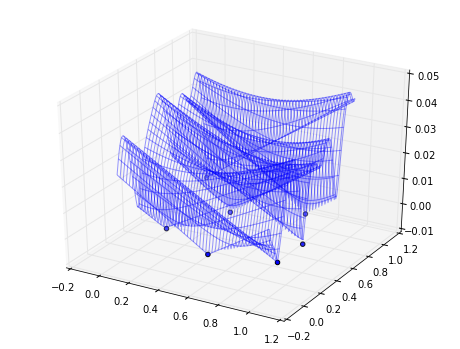

In [30]:
Z7_zero = np.zeros((7))
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_wireframe(X, Y, z7_std, rstride=2, cstride=2, alpha=0.4)
ax.scatter(X7_0, X7_1, Z7_zero)

In [31]:
best_x0 = 0
best_x1 = 0
best_val = z7_std[best_x0,best_x1]
print best_val
for i in range(100):
    for j in range(100):
        if z7_std[i,j]>best_val:
            best_x0 = i
            best_x1 = j
            best_val = z7_std[i,j]
new_point8 = [X[best_x0,best_x1], Y[best_x0, best_x1]]
print best_val, new_point8


0.0226211010668
0.0462602457832 [1.0, 0.92929292929292939]


In [32]:
y8 = OandA(new_point8[0],new_point8[1])
print y8
Y8 = np.append(Y7, y8)
X8 = np.append(X7,[new_point8], axis=0)

2.34865969676


In [33]:
print Y8, X8

[ 1.62401323  1.82044942  2.50151549  1.98151549  2.08044942  2.08401323
  1.93451828  2.3486597 ] [[ 0.          1.        ]
 [ 0.2         0.2       ]
 [ 0.4         0.6       ]
 [ 0.6         0.        ]
 [ 0.8         0.8       ]
 [ 1.          0.4       ]
 [ 1.          0.1010101 ]
 [ 1.          0.92929293]]


In [34]:
k8 = KrigingModel(X8,Y8)
print k8.trendModel
print 'beta:',k8.beta
print 'corr range:', k8.d
print 'corrrected AIC:', k8.getAICc()
print 'process variance:', k8.processVariance

[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
beta: [ 1.74583376  0.48649566]
corr range: [  0.3280905  10.       ]
corrrected AIC: 24.6876041702
process variance: 0.12047995136


error estimate:  0.0211637802172
error actual  :  0.0839361181968
cv error      :  0.118667638006


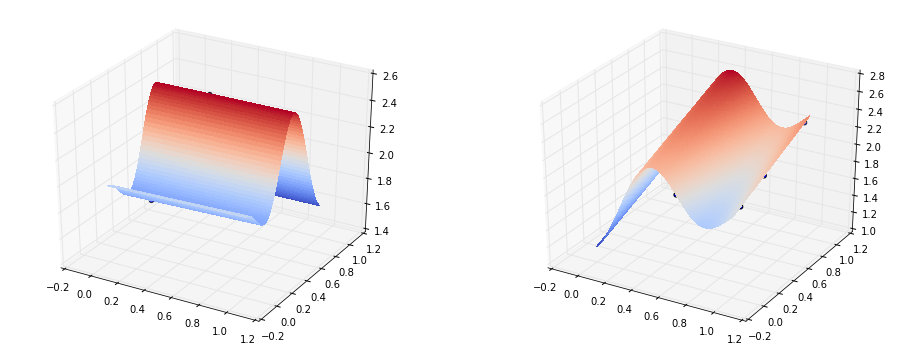

In [35]:
Z8_est = np.zeros((100,100))
Z8_std = np.zeros((100,100))
Z8_zero = np.zeros((8))
X8_0 = np.append(X7_0, new_point8[0])
X8_1 = np.append(X7_1, new_point8[1])
iea = np.append(iee,[0.0])
iee = np.append(iea,[0.0])
for i in range(100):
    for j in range(100):
        Z8_est[i,j]=k8.estimate([X[i,j],Y[i,j]])
        Z8_std[i,j]=k8.stdev([X[i,j],Y[i,j]])
        iee[2]+=Z8_std[i,j]
        iea[2]+=abs(Z[i,j]-Z8_est[i,j])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z7_est, rstride = 1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X7_0, X7_1, Y7)
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z8_est, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X8_0, X8_1, Y8)
iee[2]=iee[2]/(100*100)
iea[2]=iea[2]/(100*100)
ecv = np.append(ecv,[sqrt(k8.cvMSE)])
print "error estimate: ", iee[2]
print "error actual  : ", iea[2]
print "cv error      : ", ecv[2]


Now the 8th observation has been added. This has permitted the inclusion of a linear trend model rather than just a constant one. The three observations that lie on a single line on the right edge has significantly impacted the resulting response surface that is selected to best fit the observations. A trend model element that is linear in x1 has been added and the apparent direction of the "waves" has been turned 90 degrees - the correct direction for this specific response surface.

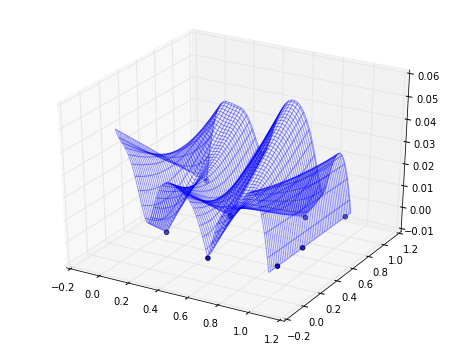

In [36]:
Z8_zero = np.zeros((8))
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_wireframe(X, Y, Z8_std, rstride=2, cstride=2, alpha=0.4)
ax.scatter(X8_0, X8_1, Z8_zero)

In [37]:
best_x0 = 0
best_x1 = 0
best_val = Z8_std[best_x0,best_x1]
print best_val
for i in range(100):
    for j in range(100):
        if Z8_std[i,j]>best_val:
            best_x0 = i
            best_x1 = j
            best_val = Z8_std[i,j]
new_point9 = [X[best_x0,best_x1], Y[best_x0, best_x1]]
print best_val, new_point9

0.0480031352073
0.0480031352073 [0.0, 0.0]


In [38]:
y9 = OandA(new_point9[0],new_point9[1])
print y9
Y9 = np.append(Y8, y9)
X9 = np.append(X8,[new_point9], axis=0)
print Y9, X9

1.12401323211
[ 1.62401323  1.82044942  2.50151549  1.98151549  2.08044942  2.08401323
  1.93451828  2.3486597   1.12401323] [[ 0.          1.        ]
 [ 0.2         0.2       ]
 [ 0.4         0.6       ]
 [ 0.6         0.        ]
 [ 0.8         0.8       ]
 [ 1.          0.4       ]
 [ 1.          0.1010101 ]
 [ 1.          0.92929293]
 [ 0.          0.        ]]


In [39]:
k9 = KrigingModel(X9,Y9)
print k9.trendModel
print 'beta:',k9.beta
print 'corr range:', k9.d
print 'corrrected AIC:', k9.getAICc()
print 'process variance:', k9.processVariance

[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
beta: [ 1.73913816  0.49766934]
corr range: [  0.29998726  10.        ]
corrrected AIC: 10.4883794396
process variance: 0.0968154613385


error estimate:  0.0214036485079
error actual  :  0.0822424814257
cv error      :  0.0582136901532


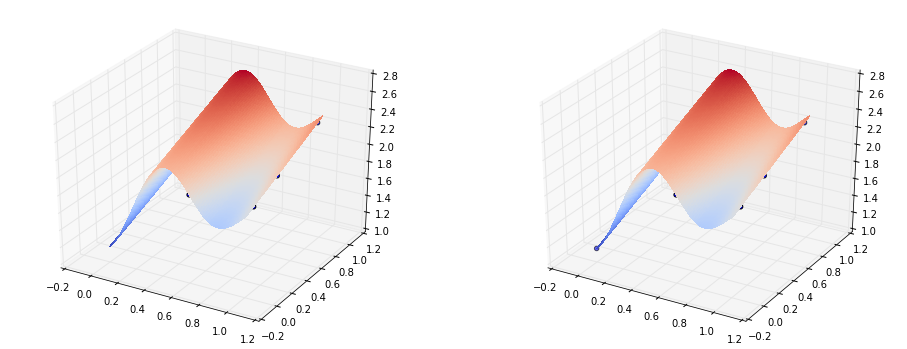

In [40]:
Z9_est = np.zeros((100,100))
Z9_std = np.zeros((100,100))
Z9_zero = np.zeros((9))
X9_0 = np.append(X8_0, new_point9[0])
X9_1 = np.append(X8_1, new_point9[1])
iea = np.append(iee,[0.0])
iee = np.append(iea,[0.0])

for i in range(100):
    for j in range(100):
        Z9_est[i,j]=k9.estimate([X[i,j],Y[i,j]])
        Z9_std[i,j]=k9.stdev([X[i,j],Y[i,j]])
        iee[3]+=Z9_std[i,j]
        iea[3]+=abs(Z[i,j]-Z9_est[i,j])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z8_est, rstride = 1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X8_0, X8_1, Y8)
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z9_est, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X9_0, X9_1, Y9)
iee[3]=iee[3]/(100*100)
iea[3]=iea[3]/(100*100)
ecv = np.append(ecv,[sqrt(k9.cvMSE)])
print "error estimate: ", iee[3]
print "error actual  : ", iea[3]
print "cv error      : ", ecv[3]

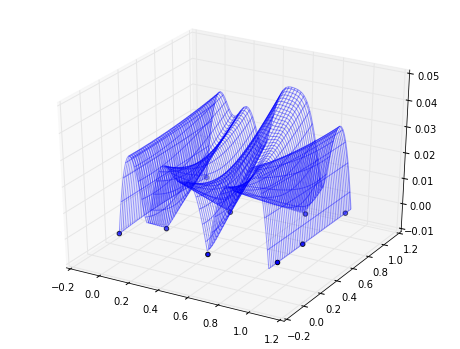

In [41]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_wireframe(X, Y, Z9_std, rstride=2, cstride=2, alpha=0.4)
ax.scatter(X9_0, X9_1, Z9_zero)

In [42]:
best_x0 = 0
best_x1 = 0
best_val = Z9_std[best_x0,best_x1]
print best_val
for i in range(100):
    for j in range(100):
        if Z9_std[i,j]>best_val:
            best_x0 = i
            best_x1 = j
            best_val = Z9_std[i,j]
new_point10 = [X[best_x0,best_x1], Y[best_x0, best_x1]]
print best_val, new_point10

3.70921886017e-08
0.0421569672095 [0.5757575757575758, 1.0]


In [43]:
y10 = OandA(new_point10[0],new_point10[1])
print y10
Y10 = np.append(Y9, y10)
X10 = np.append(X9,[new_point10], axis=0)
print Y10, X10

2.45721001873
[ 1.62401323  1.82044942  2.50151549  1.98151549  2.08044942  2.08401323
  1.93451828  2.3486597   1.12401323  2.45721002] [[ 0.          1.        ]
 [ 0.2         0.2       ]
 [ 0.4         0.6       ]
 [ 0.6         0.        ]
 [ 0.8         0.8       ]
 [ 1.          0.4       ]
 [ 1.          0.1010101 ]
 [ 1.          0.92929293]
 [ 0.          0.        ]
 [ 0.57575758  1.        ]]


In [44]:
k10 = KrigingModel(X10,Y10)
print k10.trendModel
print 'beta:',k10.beta
print 'corr range:', k10.d
print 'corrrected AIC:', k10.getAICc()
print 'process variance:', k10.processVariance

[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
beta: [ 1.74815269  0.47654969]
corr range: [  0.31364569  10.        ]
corrrected AIC: 2.98385773
process variance: 0.112619199275


error estimate:  0.0166035218979
error actual  :  0.0804970502535
cv error      :  0.0579889697747


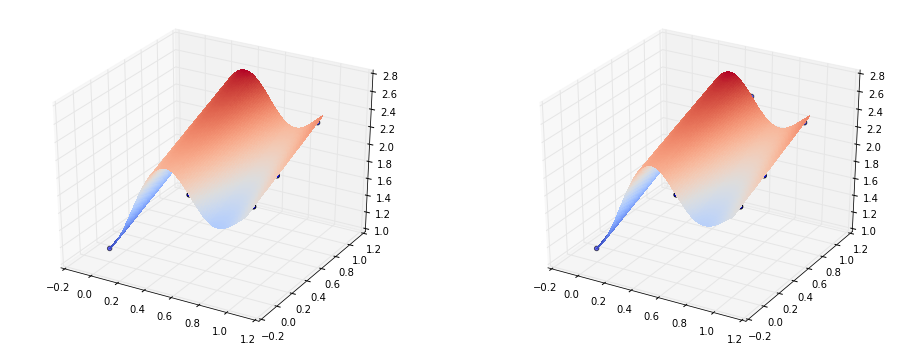

In [45]:
Z10_est = np.zeros((100,100))
Z10_std = np.zeros((100,100))
Z10_zero = np.zeros((10))
X10_0 = np.append(X9_0, new_point10[0])
X10_1 = np.append(X9_1, new_point10[1])
iea = np.append(iee,[0.0])
iee = np.append(iea,[0.0])

for i in range(100):
    for j in range(100):
        Z10_est[i,j]=k10.estimate([X[i,j],Y[i,j]])
        Z10_std[i,j]=k10.stdev([X[i,j],Y[i,j]])
        iee[4]+=Z10_std[i,j]
        iea[4]+=abs(Z[i,j]-Z10_est[i,j])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z9_est, rstride = 1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X9_0, X9_1, Y9)
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z10_est, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X10_0, X10_1, Y10)
iee[4]=iee[4]/(100*100)
iea[4]=iea[4]/(100*100)
ecv = np.append(ecv,[sqrt(k10.cvMSE)])
print "error estimate: ", iee[4]
print "error actual  : ", iea[4]
print "cv error      : ", ecv[4]

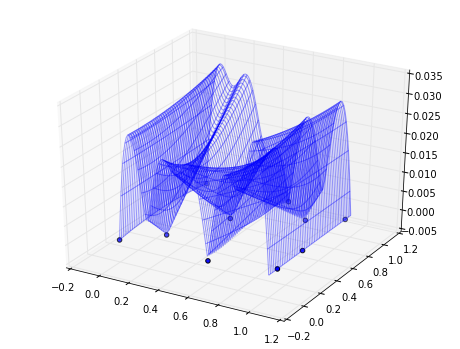

In [46]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_wireframe(X, Y, Z10_std, rstride=2, cstride=2, alpha=0.4)
ax.scatter(X10_0, X10_1, Z10_zero)

In [47]:
best_x0 = 0
best_x1 = 0
best_val = Z10_std[best_x0,best_x1]
print best_val
for i in range(100):
    for j in range(100):
        if Z10_std[i,j]>best_val:
            best_x0 = i
            best_x1 = j
            best_val = Z10_std[i,j]
new_point11 = [X[best_x0,best_x1], Y[best_x0, best_x1]]
print best_val, new_point11

2.15086025531e-08
0.0323657164648 [0.89898989898989912, 0.0]


In [48]:
y11 = OandA(new_point11[0],new_point11[1])
print y11
Y11 = np.append(Y10, y11)
X11 = np.append(X10,[new_point11], axis=0)
print Y11, X11

1.66873522134
[ 1.62401323  1.82044942  2.50151549  1.98151549  2.08044942  2.08401323
  1.93451828  2.3486597   1.12401323  2.45721002  1.66873522] [[ 0.          1.        ]
 [ 0.2         0.2       ]
 [ 0.4         0.6       ]
 [ 0.6         0.        ]
 [ 0.8         0.8       ]
 [ 1.          0.4       ]
 [ 1.          0.1010101 ]
 [ 1.          0.92929293]
 [ 0.          0.        ]
 [ 0.57575758  1.        ]
 [ 0.8989899   0.        ]]


In [49]:
k11 = KrigingModel(X11,Y11)
print k11.trendModel
print 'beta:',k11.beta
print 'corr range:', k11.d
print 'corrrected AIC:', k11.getAICc()
print 'process variance:', k11.processVariance

[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
beta: [ 1.77448344  0.48534236]
corr range: [  0.20682908  10.        ]
corrrected AIC: -1.82503916034
process variance: 0.0812177975171


error estimate:  0.0353199328118
error actual  :  0.0583815003218
cv error      :  0.099633204509


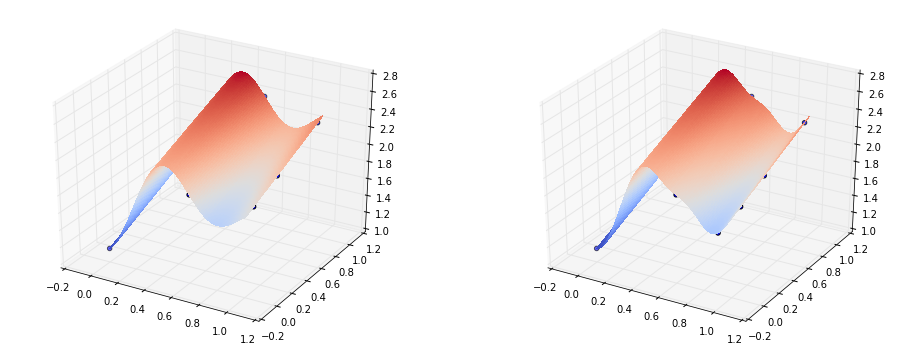

In [50]:
Z11_est = np.zeros((100,100))
Z11_std = np.zeros((100,100))
Z11_zero = np.zeros((11))
X11_0 = np.append(X10_0, new_point11[0])
X11_1 = np.append(X10_1, new_point11[1])
iea = np.append(iee,[0.0])
iee = np.append(iea,[0.0])

for i in range(100):
    for j in range(100):
        Z11_est[i,j]=k11.estimate([X[i,j],Y[i,j]])
        Z11_std[i,j]=k11.stdev([X[i,j],Y[i,j]])
        iee[5]+=Z11_std[i,j]
        iea[5]+=abs(Z[i,j]-Z11_est[i,j])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z10_est, rstride = 1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X10_0, X10_1, Y10)
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z11_est, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X11_0, X11_1, Y11)
iee[5]=iee[5]/(100*100)
iea[5]=iea[5]/(100*100)
ecv = np.append(ecv,[sqrt(k11.cvMSE)])
print "error estimate: ", iee[5]
print "error actual  : ", iea[5]
print "cv error      : ", ecv[5]

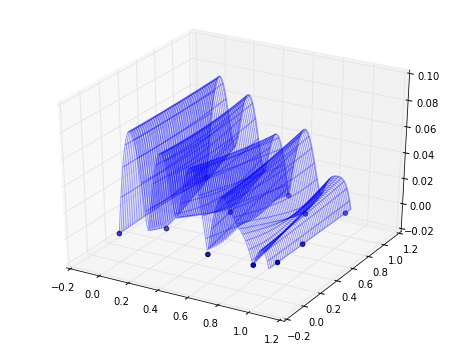

In [51]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_wireframe(X, Y, Z11_std, rstride=2, cstride=2, alpha=0.4)
ax.scatter(X11_0, X11_1, Z11_zero)

In [52]:
best_x0 = 0
best_x1 = 0
best_val = Z11_std[best_x0,best_x1]
print best_val
for i in range(100):
    for j in range(100):
        if Z11_std[i,j]>best_val:
            best_x0 = i
            best_x1 = j
            best_val = Z11_std[i,j]
new_point12 = [X[best_x0,best_x1], Y[best_x0, best_x1]]
print best_val, new_point12

2.58313187665e-08
0.0819969730765 [0.10101010101010102, 1.0]


In [53]:
y12 = OandA(new_point12[0],new_point12[1])
print y12
Y12 = np.append(Y11, y12)
X12 = np.append(X11,[new_point12], axis=0)
print Y12, X12

1.81277562538
[ 1.62401323  1.82044942  2.50151549  1.98151549  2.08044942  2.08401323
  1.93451828  2.3486597   1.12401323  2.45721002  1.66873522  1.81277563] [[ 0.          1.        ]
 [ 0.2         0.2       ]
 [ 0.4         0.6       ]
 [ 0.6         0.        ]
 [ 0.8         0.8       ]
 [ 1.          0.4       ]
 [ 1.          0.1010101 ]
 [ 1.          0.92929293]
 [ 0.          0.        ]
 [ 0.57575758  1.        ]
 [ 0.8989899   0.        ]
 [ 0.1010101   1.        ]]


In [54]:
k12 = KrigingModel(X12,Y12)
print k12.trendModel
print 'beta:',k12.beta
print 'corr range:', k12.d
print 'corrrected AIC:', k12.getAICc()
print 'process variance:', k12.processVariance

[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
beta: [ 1.78254578  0.48359703]
corr range: [  0.23206964  10.        ]
corrrected AIC: -7.26767790754
process variance: 0.0852056430427


error estimate:  0.0179665380896
error actual  :  0.0577209123002
cv error      :  0.066135344265


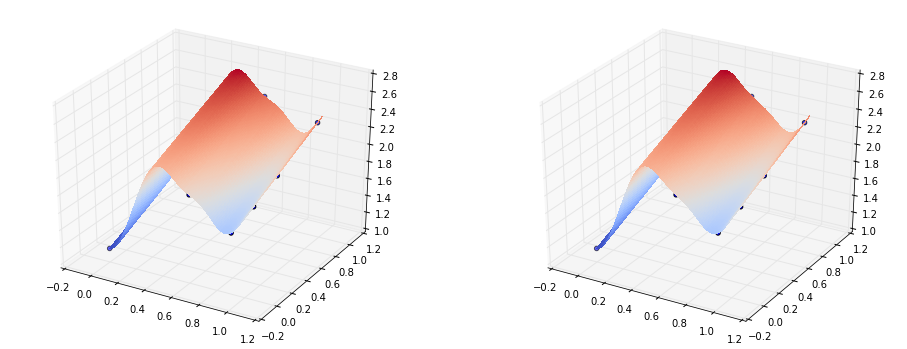

In [55]:
Z12_est = np.zeros((100,100))
Z12_std = np.zeros((100,100))
Z12_zero = np.zeros((12))
X12_0 = np.append(X11_0, new_point12[0])
X12_1 = np.append(X11_1, new_point12[1])
iea = np.append(iee,[0.0])
iee = np.append(iea,[0.0])

for i in range(100):
    for j in range(100):
        Z12_est[i,j]=k12.estimate([X[i,j],Y[i,j]])
        Z12_std[i,j]=k12.stdev([X[i,j],Y[i,j]])
        iee[6]+=Z12_std[i,j]
        iea[6]+=abs(Z[i,j]-Z12_est[i,j])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z11_est, rstride = 1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X11_0, X11_1, Y11)
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z12_est, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X12_0, X12_1, Y12)
iee[6]=iee[6]/(100*100)
iea[6]=iea[6]/(100*100)
ecv = np.append(ecv, [sqrt(k12.cvMSE)])
print "error estimate: ", iee[6]
print "error actual  : ", iea[6]
print "cv error      : ", ecv[6]

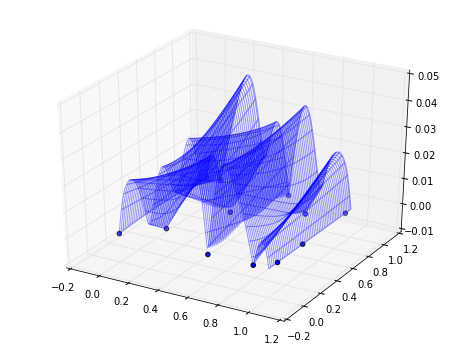

In [56]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_wireframe(X, Y, Z12_std, rstride=2, cstride=2, alpha=0.4)
ax.scatter(X12_0, X12_1, Z12_zero)

In [57]:
best_x0 = 0
best_x1 = 0
best_val = Z12_std[best_x0,best_x1]
print best_val
for i in range(100):
    for j in range(100):
        if Z12_std[i,j]>best_val:
            best_x0 = i
            best_x1 = j
            best_val = Z12_std[i,j]
new_point13 = [X[best_x0,best_x1], Y[best_x0, best_x1]]
print best_val, new_point13

2.08601876065e-08
0.0436603440495 [0.29292929292929293, 1.0]


In [58]:
y13 = OandA(new_point13[0],new_point13[1])
print y13
Y13 = np.append(Y12, y13)
X13 = np.append(X12,[new_point13], axis=0)
print Y13, X13

2.60505388402
[ 1.62401323  1.82044942  2.50151549  1.98151549  2.08044942  2.08401323
  1.93451828  2.3486597   1.12401323  2.45721002  1.66873522  1.81277563
  2.60505388] [[ 0.          1.        ]
 [ 0.2         0.2       ]
 [ 0.4         0.6       ]
 [ 0.6         0.        ]
 [ 0.8         0.8       ]
 [ 1.          0.4       ]
 [ 1.          0.1010101 ]
 [ 1.          0.92929293]
 [ 0.          0.        ]
 [ 0.57575758  1.        ]
 [ 0.8989899   0.        ]
 [ 0.1010101   1.        ]
 [ 0.29292929  1.        ]]


In [59]:
k13 = KrigingModel(X13,Y13)
print k13.trendModel
print 'beta:',k13.beta
print 'corr range:', k13.d
print 'corrrected AIC:', k13.getAICc()
print 'process variance:', k13.processVariance

[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
beta: [ 1.77440654  0.49127873]
corr range: [  0.22869442  10.        ]
corrrected AIC: -12.280764598
process variance: 0.0821998176655


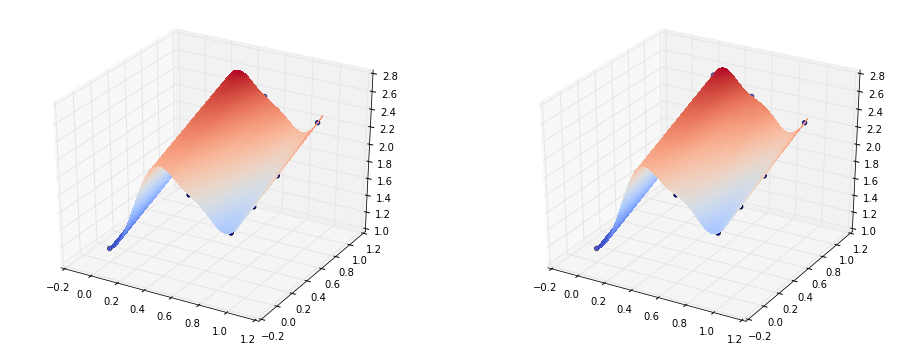

In [60]:
Z13_est = np.zeros((100,100))
Z13_std = np.zeros((100,100))
Z13_zero = np.zeros((13))
X13_0 = np.append(X12_0, new_point13[0])
X13_1 = np.append(X12_1, new_point13[1])

for i in range(100):
    for j in range(100):
        Z13_est[i,j]=k13.estimate([X[i,j],Y[i,j]])
        Z13_std[i,j]=k13.stdev([X[i,j],Y[i,j]])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z12_est, rstride = 1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X12_0, X12_1, Y12)
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z13_est, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X13_0, X13_1, Y13)

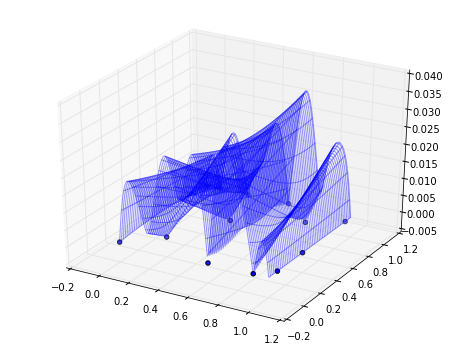

In [61]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_wireframe(X, Y, Z13_std, rstride=2, cstride=2, alpha=0.4)
ax.scatter(X13_0, X13_1, Z13_zero)

In [62]:
best_x0 = 0
best_x1 = 0
best_val = Z13_std[best_x0,best_x1]
print best_val
for i in range(100):
    for j in range(100):
        if Z13_std[i,j]>best_val:
            best_x0 = i
            best_x1 = j
            best_val = Z13_std[i,j]
new_point14 = [X[best_x0,best_x1], Y[best_x0, best_x1]]
print best_val, new_point14

1.28167169878e-08
0.0338822513677 [0.68686868686868696, 1.0]


In [63]:
y14 = OandA(new_point14[0],new_point14[1])
print y14
Y14 = np.append(Y13, y14)
X14 = np.append(X13,[new_point14], axis=0)
print Y14, X14

2.25301568583
[ 1.62401323  1.82044942  2.50151549  1.98151549  2.08044942  2.08401323
  1.93451828  2.3486597   1.12401323  2.45721002  1.66873522  1.81277563
  2.60505388  2.25301569] [[ 0.          1.        ]
 [ 0.2         0.2       ]
 [ 0.4         0.6       ]
 [ 0.6         0.        ]
 [ 0.8         0.8       ]
 [ 1.          0.4       ]
 [ 1.          0.1010101 ]
 [ 1.          0.92929293]
 [ 0.          0.        ]
 [ 0.57575758  1.        ]
 [ 0.8989899   0.        ]
 [ 0.1010101   1.        ]
 [ 0.29292929  1.        ]
 [ 0.68686869  1.        ]]


In [64]:
k14 = KrigingModel(X14,Y14)
print k14.trendModel
print 'beta:',k14.beta
print 'corr range:', k14.d
print 'corrrected AIC:', k14.getAICc()
print 'process variance:', k14.processVariance

[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
beta: [ 1.78107105  0.48446012]
corr range: [  0.1975388  10.       ]
corrrected AIC: -12.0378535566
process variance: 0.0896010956973


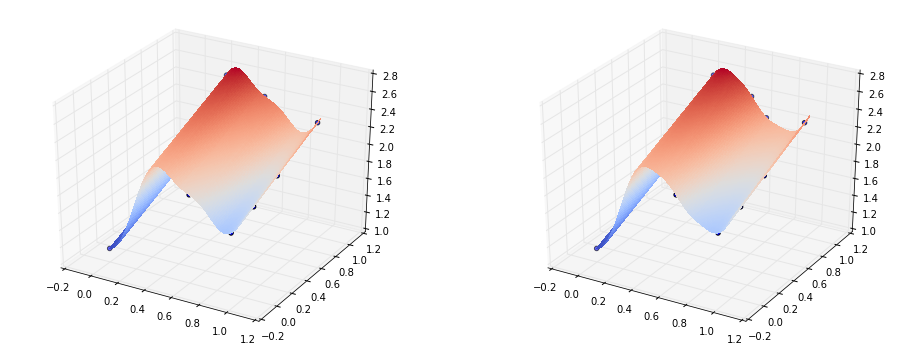

In [65]:
Z14_est = np.zeros((100,100))
Z14_std = np.zeros((100,100))
Z14_zero = np.zeros((14))
X14_0 = np.append(X13_0, new_point14[0])
X14_1 = np.append(X13_1, new_point14[1])

for i in range(100):
    for j in range(100):
        Z14_est[i,j]=k14.estimate([X[i,j],Y[i,j]])
        Z14_std[i,j]=k14.stdev([X[i,j],Y[i,j]])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z13_est, rstride = 1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X13_0, X13_1, Y13)
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z14_est, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X14_0, X14_1, Y14)

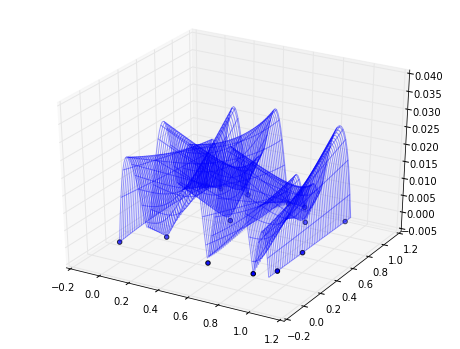

In [66]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_wireframe(X, Y, Z14_std, rstride=2, cstride=2, alpha=0.4)
ax.scatter(X14_0, X14_1, Z14_zero)

In [67]:
best_x0 = 0
best_x1 = 0
best_val = Z14_std[best_x0,best_x1]
print best_val
for i in range(100):
    for j in range(100):
        if Z14_std[i,j]>best_val:
            best_x0 = i
            best_x1 = j
            best_val = Z14_std[i,j]
new_point15 = [X[best_x0,best_x1], Y[best_x0, best_x1]]
print best_val, new_point15

4.21976524299e-08
0.0372339883584 [0.32323232323232326, 0.0]


In [68]:
y15 = OandA(new_point15[0],new_point15[1])
print y15
Y15 = np.append(Y14, y15)
X15 = np.append(X14,[new_point15], axis=0)
print Y15, X15

2.18812762195
[ 1.62401323  1.82044942  2.50151549  1.98151549  2.08044942  2.08401323
  1.93451828  2.3486597   1.12401323  2.45721002  1.66873522  1.81277563
  2.60505388  2.25301569  2.18812762] [[ 0.          1.        ]
 [ 0.2         0.2       ]
 [ 0.4         0.6       ]
 [ 0.6         0.        ]
 [ 0.8         0.8       ]
 [ 1.          0.4       ]
 [ 1.          0.1010101 ]
 [ 1.          0.92929293]
 [ 0.          0.        ]
 [ 0.57575758  1.        ]
 [ 0.8989899   0.        ]
 [ 0.1010101   1.        ]
 [ 0.29292929  1.        ]
 [ 0.68686869  1.        ]
 [ 0.32323232  0.        ]]


In [69]:
k15 = KrigingModel(X15,Y15)
print k15.trendModel
print 'beta:',k15.beta
print 'corr range:', k15.d
print 'corrrected AIC:', k15.getAICc()
print 'process variance:', k15.processVariance

[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
beta: [ 1.77910675  0.48037923]
corr range: [  0.19017137  10.        ]
corrrected AIC: -17.4005184
process variance: 0.0791940053025


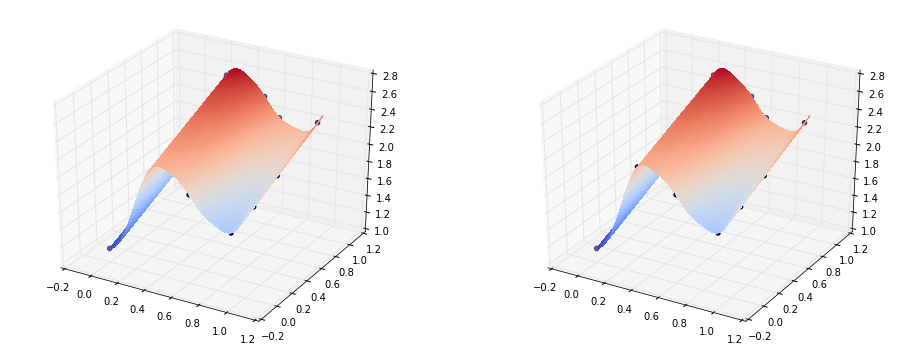

In [70]:
Z15_est = np.zeros((100,100))
Z15_std = np.zeros((100,100))
Z15_zero = np.zeros((15))
X15_0 = np.append(X14_0, new_point15[0])
X15_1 = np.append(X14_1, new_point15[1])

for i in range(100):
    for j in range(100):
        Z15_est[i,j]=k15.estimate([X[i,j],Y[i,j]])
        Z15_std[i,j]=k15.stdev([X[i,j],Y[i,j]])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z14_est, rstride = 1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X14_0, X14_1, Y14)
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z15_est, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X15_0, X15_1, Y15)

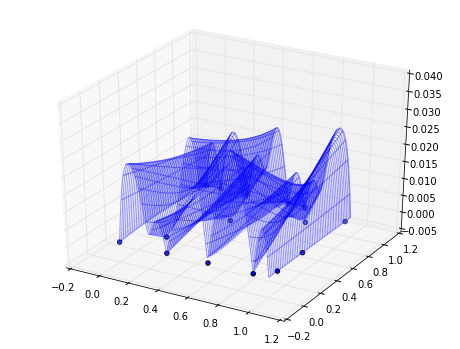

In [71]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_wireframe(X, Y, Z15_std, rstride=2, cstride=2, alpha=0.4)
ax.scatter(X15_0, X15_1, Z15_zero)

In [72]:
best_x0 = 0
best_x1 = 0
best_val = Z15_std[best_x0,best_x1]
print best_val
for i in range(100):
    for j in range(100):
        if Z15_std[i,j]>best_val:
            best_x0 = i
            best_x1 = j
            best_val = Z15_std[i,j]
new_point16 = [X[best_x0,best_x1], Y[best_x0, best_x1]]
print best_val, new_point16

2.84410209822e-08
0.034229813798 [0.48484848484848486, 0.0]


In [73]:
y16 = OandA(new_point16[0],new_point16[1])
print y16
Y16 = np.append(Y15, y16)
X16 = np.append(X15,[new_point16], axis=0)
print Y16, X16

1.69859252059
[ 1.62401323  1.82044942  2.50151549  1.98151549  2.08044942  2.08401323
  1.93451828  2.3486597   1.12401323  2.45721002  1.66873522  1.81277563
  2.60505388  2.25301569  2.18812762  1.69859252] [[ 0.          1.        ]
 [ 0.2         0.2       ]
 [ 0.4         0.6       ]
 [ 0.6         0.        ]
 [ 0.8         0.8       ]
 [ 1.          0.4       ]
 [ 1.          0.1010101 ]
 [ 1.          0.92929293]
 [ 0.          0.        ]
 [ 0.57575758  1.        ]
 [ 0.8989899   0.        ]
 [ 0.1010101   1.        ]
 [ 0.29292929  1.        ]
 [ 0.68686869  1.        ]
 [ 0.32323232  0.        ]
 [ 0.48484848  0.        ]]


In [74]:
k16 = KrigingModel(X16,Y16)
print k16.trendModel
print 'beta:',k16.beta
print 'corr range:', k16.d
print 'corrrected AIC:', k16.getAICc()
print 'process variance:', k16.processVariance

[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
beta: [ 1.72925717  0.51193872]
corr range: [  0.10841532  10.        ]
corrrected AIC: -11.1035304532
process variance: 0.0653965622505


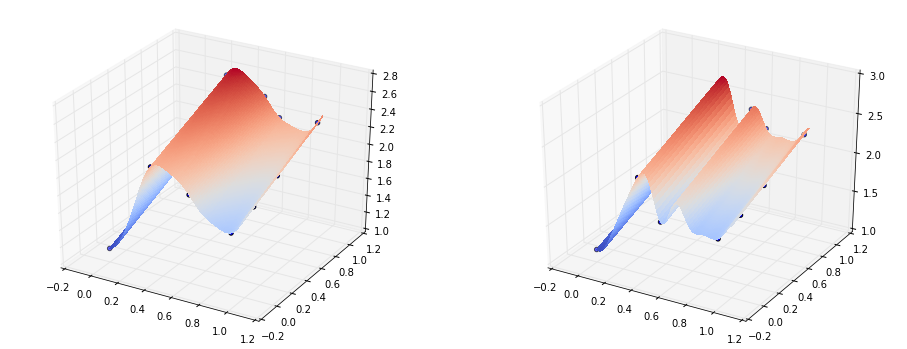

In [75]:
Z16_est = np.zeros((100,100))
Z16_std = np.zeros((100,100))
Z16_zero = np.zeros((16))
X16_0 = np.append(X15_0, new_point16[0])
X16_1 = np.append(X15_1, new_point16[1])

for i in range(100):
    for j in range(100):
        Z16_est[i,j]=k16.estimate([X[i,j],Y[i,j]])
        Z16_std[i,j]=k16.stdev([X[i,j],Y[i,j]])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z15_est, rstride = 1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X15_0, X15_1, Y15)
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z16_est, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X16_0, X16_1, Y16)

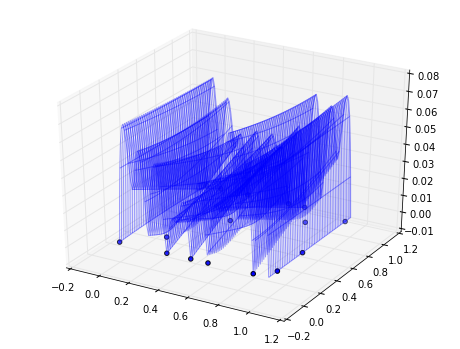

In [76]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_wireframe(X, Y, Z16_std, rstride=2, cstride=2, alpha=0.4)
ax.scatter(X16_0, X16_1, Z16_zero)

In [77]:
best_x0 = 0
best_x1 = 0
best_val = Z16_std[best_x0,best_x1]
print best_val
for i in range(100):
    for j in range(100):
        if Z16_std[i,j]>best_val:
            best_x0 = i
            best_x1 = j
            best_val = Z16_std[i,j]
new_point17 = [X[best_x0,best_x1], Y[best_x0, best_x1]]
print best_val, new_point17

2.28638215927e-08
0.0757253242427 [0.74747474747474751, 0.0]


In [78]:
y17 = OandA(new_point17[0],new_point17[1])
print y17
Y17 = np.append(Y16, y17)
X17 = np.append(X16,[new_point17], axis=0)
print Y17, X17

1.70320012083
[ 1.62401323  1.82044942  2.50151549  1.98151549  2.08044942  2.08401323
  1.93451828  2.3486597   1.12401323  2.45721002  1.66873522  1.81277563
  2.60505388  2.25301569  2.18812762  1.69859252  1.70320012] [[ 0.          1.        ]
 [ 0.2         0.2       ]
 [ 0.4         0.6       ]
 [ 0.6         0.        ]
 [ 0.8         0.8       ]
 [ 1.          0.4       ]
 [ 1.          0.1010101 ]
 [ 1.          0.92929293]
 [ 0.          0.        ]
 [ 0.57575758  1.        ]
 [ 0.8989899   0.        ]
 [ 0.1010101   1.        ]
 [ 0.29292929  1.        ]
 [ 0.68686869  1.        ]
 [ 0.32323232  0.        ]
 [ 0.48484848  0.        ]
 [ 0.74747475  0.        ]]
